# Ray Tracing with torchscience.graphics

This notebook builds a complete GPU-accelerated ray tracer using `torchscience`, culminating in the classic "Ray Tracing in One Weekend" cover scene.

**What we'll build:**
- Camera ray generation with perspective projection
- Ray-sphere intersection (analytic)
- Physically-based materials: diffuse, metal, glass
- Cook-Torrance BRDF for realistic specular highlights
- Tone mapping for HDR rendering
- Interactive parameter exploration

**torchscience modules used:**
- `torchscience.graphics.shading` - Phong, Cook-Torrance BRDF
- `torchscience.graphics.color` - sRGB ↔ HSV conversion
- `torchscience.graphics.tone_mapping` - Reinhard tone mapping
- `torchscience.geometry` - Ray-triangle intersection (bonus)

Let's begin!

In [1]:
import math
from dataclasses import dataclass
from typing import Optional

import plotly.express as px
import torch
import torch.nn.functional as F

from torchscience.geometry.transform import reflect, refract
from torchscience.graphics.color import (
    hsv_to_srgb,
    srgb_linear_to_srgb,
    srgb_to_hsv,
)
from torchscience.graphics.shading import cook_torrance, schlick_reflectance
from torchscience.graphics.tone_mapping import reinhard

# Optional: interactive widgets
try:
    import ipywidgets as widgets

    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("ipywidgets not installed - interactive demos will be static")

# Configuration
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Helper to display images
def show_image(img, title="", figsize=(10, 6)):
    """Display a torch tensor as an image using Plotly."""
    if img.device.type != "cpu":
        img = img.cpu()
    img_np = (img.clamp(0, 1).numpy() * 255).astype("uint8")

    fig = px.imshow(img_np)
    fig.update_layout(
        title=title,
        width=figsize[0] * 80,
        height=figsize[1] * 80,
        xaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
        yaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
        margin=dict(l=10, r=10, t=40 if title else 10, b=10),
    )
    fig.show()

Using device: cpu


---
## Part 1: Generating Camera Rays

Every ray tracer starts with a camera. We'll create a simple pinhole camera that generates rays for each pixel.

**Camera model:**
- Position at `lookfrom`
- Looking toward `lookat`
- Field of view (FOV) controls zoom
- Aspect ratio matches image dimensions

In [2]:
@dataclass
class Camera:
    """Simple pinhole camera for ray generation."""

    lookfrom: torch.Tensor  # Camera position
    lookat: torch.Tensor  # Point to look at
    vup: torch.Tensor  # Up vector
    vfov: float  # Vertical field of view in degrees
    aspect_ratio: float  # Width / height

    def __post_init__(self):
        # Compute camera basis vectors
        theta = math.radians(self.vfov)
        h = math.tan(theta / 2)
        viewport_height = 2.0 * h
        viewport_width = self.aspect_ratio * viewport_height

        # Camera coordinate system
        w = F.normalize(self.lookfrom - self.lookat, dim=-1)  # Back
        u = F.normalize(torch.linalg.cross(self.vup, w), dim=-1)  # Right
        v = torch.linalg.cross(w, u)  # Up

        self.origin = self.lookfrom
        self.horizontal = viewport_width * u
        self.vertical = viewport_height * v
        self.lower_left = (
            self.origin - self.horizontal / 2 - self.vertical / 2 - w
        )

    def get_ray_directions(
        self, u: torch.Tensor, v: torch.Tensor
    ) -> torch.Tensor:
        """
        Generate ray directions for normalized coordinates.

        Args:
            u: Horizontal coordinate in [0, 1], shape (height, width)
            v: Vertical coordinate in [0, 1], shape (height, width)

        Returns:
            Normalized ray directions, shape (height, width, 3)
        """
        # Compute point on image plane
        point = (
            self.lower_left
            + u.unsqueeze(-1) * self.horizontal
            + v.unsqueeze(-1) * self.vertical
        )
        direction = point - self.origin
        return F.normalize(direction, dim=-1)


def generate_pixel_coords(
    width: int, height: int, device="cpu"
) -> tuple[torch.Tensor, torch.Tensor]:
    """Generate normalized (u, v) coordinates for each pixel.

    Returns:
        u, v: Both shape (height, width) - u is horizontal [0,1], v is vertical [0,1]
    """
    # Pixel centers at (i + 0.5) / dim
    u_vals = (
        torch.arange(width, device=device, dtype=torch.float32) + 0.5
    ) / width
    v_vals = (
        torch.arange(height, device=device, dtype=torch.float32) + 0.5
    ) / height
    # Flip v so y increases upward (image row 0 = top = high v)
    v_vals = 1.0 - v_vals
    # Create grid: indexing='xy' gives shape (height, width)
    uu, vv = torch.meshgrid(u_vals, v_vals, indexing="ij")
    return uu.T, vv.T  # Transpose to get (height, width)

Pixel coords shape: u=torch.Size([225, 400]), v=torch.Size([225, 400])
Ray directions shape: torch.Size([225, 400, 3])


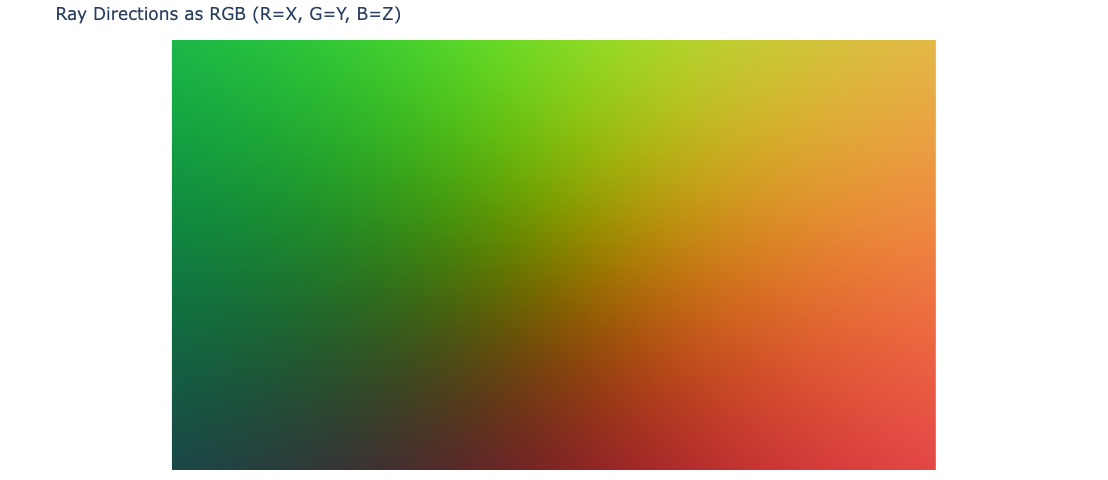

In [3]:
# Test: Generate rays and visualize directions as colors
width, height = 400, 225

camera = Camera(
    lookfrom=torch.tensor([0.0, 0.0, 0.0], device=device),
    lookat=torch.tensor([0.0, 0.0, -1.0], device=device),
    vup=torch.tensor([0.0, 1.0, 0.0], device=device),
    vfov=90.0,
    aspect_ratio=width / height,
)

u, v = generate_pixel_coords(width, height, device=device)
ray_dirs = camera.get_ray_directions(u, v)  # Shape: (height, width, 3)

print(f"Pixel coords shape: u={u.shape}, v={v.shape}")
print(f"Ray directions shape: {ray_dirs.shape}")

# Visualize ray directions as RGB
dir_colors = (ray_dirs + 1) / 2  # Map [-1, 1] to [0, 1]
show_image(dir_colors, "Ray Directions as RGB (R=X, G=Y, B=Z)")

---
## Part 2: Sky Gradient

Before hitting any objects, rays that miss everything see the sky. We'll use a simple vertical gradient from white (horizon) to blue (zenith).

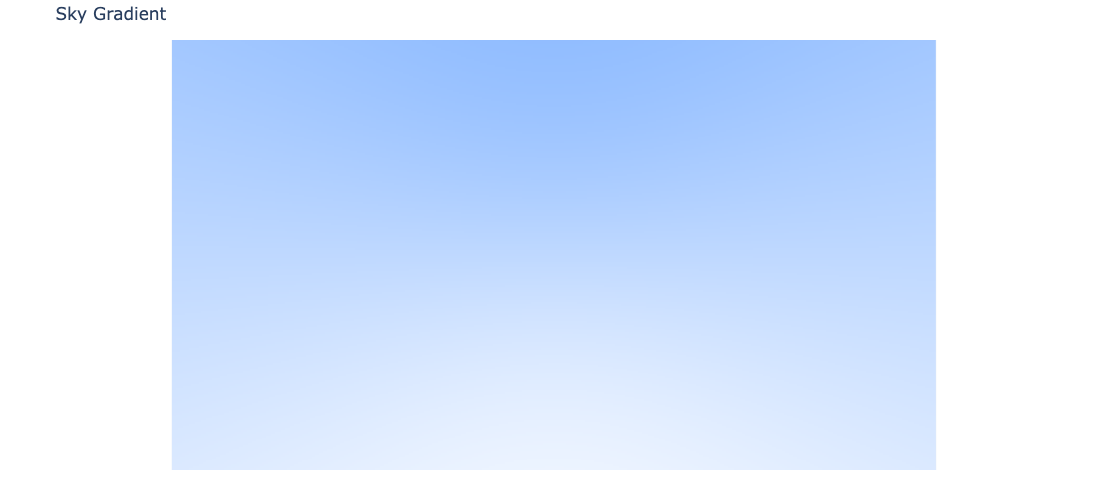

In [4]:
def sky_color(direction: torch.Tensor) -> torch.Tensor:
    """
    Compute sky color based on ray direction.

    Args:
        direction: Normalized ray directions, shape (..., 3)

    Returns:
        RGB colors, shape (..., 3)
    """
    # Blend based on y component (vertical)
    t = 0.5 * (direction[..., 1] + 1.0)  # Map y from [-1,1] to [0,1]

    # Linear interpolation: white at horizon, blue at top
    white = torch.tensor([1.0, 1.0, 1.0], device=direction.device)
    blue = torch.tensor([0.5, 0.7, 1.0], device=direction.device)

    return (1.0 - t).unsqueeze(-1) * white + t.unsqueeze(-1) * blue


# Render just the sky
sky = sky_color(ray_dirs)
show_image(sky, "Sky Gradient")

---
## Part 3: Ray-Sphere Intersection

The heart of our ray tracer: determining where rays hit spheres.

**The math:**
A point P is on a sphere centered at C with radius r if: |P - C|² = r²

A point on a ray is: P(t) = O + t·D (origin + t × direction)

Substituting: |O + t·D - C|² = r²

This is a quadratic in t: at² + bt + c = 0
- a = D·D
- b = 2·D·(O - C)
- c = (O - C)·(O - C) - r²

The discriminant tells us:
- < 0: no intersection (ray misses)
- = 0: one intersection (ray grazes)
- > 0: two intersections (ray enters and exits)

In [5]:
@dataclass
class Sphere:
    """A sphere in 3D space."""

    center: torch.Tensor  # Shape (3,)
    radius: float
    material_id: int = 0  # Index into material list


@dataclass
class HitRecord:
    """Information about a ray-object intersection."""

    t: torch.Tensor  # Distance along ray
    point: torch.Tensor  # Hit point in world space
    normal: torch.Tensor  # Surface normal (outward)
    front_face: torch.Tensor  # True if ray hit front of surface
    material_id: torch.Tensor  # Material index
    hit: torch.Tensor  # Boolean mask of valid hits


def hit_sphere(
    origins: torch.Tensor,  # (..., 3)
    directions: torch.Tensor,  # (..., 3)
    sphere: Sphere,
    t_min: float = 0.001,
    t_max: float = float("inf"),
) -> HitRecord:
    """
    Ray-sphere intersection test.

    Returns HitRecord with hit=False for rays that miss.
    """
    oc = origins - sphere.center  # Origin to center

    # Quadratic coefficients
    a = (directions * directions).sum(dim=-1)  # D·D
    half_b = (oc * directions).sum(dim=-1)  # (O-C)·D
    c = (oc * oc).sum(dim=-1) - sphere.radius**2

    discriminant = half_b**2 - a * c

    # Initialize outputs
    batch_shape = origins.shape[:-1]
    device = origins.device

    hit = discriminant >= 0
    t = torch.full(batch_shape, float("inf"), device=device)

    # Compute t for hits
    sqrt_d = torch.sqrt(discriminant.clamp(min=0))
    t1 = (-half_b - sqrt_d) / a  # Closer intersection
    t2 = (-half_b + sqrt_d) / a  # Farther intersection

    # Use t1 if in range, else try t2
    use_t1 = hit & (t1 >= t_min) & (t1 <= t_max)
    use_t2 = hit & ~use_t1 & (t2 >= t_min) & (t2 <= t_max)

    t = torch.where(use_t1, t1, t)
    t = torch.where(use_t2, t2, t)
    hit = use_t1 | use_t2

    # Compute hit point and normal
    point = origins + t.unsqueeze(-1) * directions
    outward_normal = (point - sphere.center) / sphere.radius

    # Determine if we hit front or back face
    front_face = (directions * outward_normal).sum(dim=-1) < 0
    normal = torch.where(
        front_face.unsqueeze(-1), outward_normal, -outward_normal
    )

    # Material ID
    material_id = torch.full(
        batch_shape, sphere.material_id, device=device, dtype=torch.long
    )

    return HitRecord(
        t=t,
        point=point,
        normal=normal,
        front_face=front_face,
        material_id=material_id,
        hit=hit,
    )

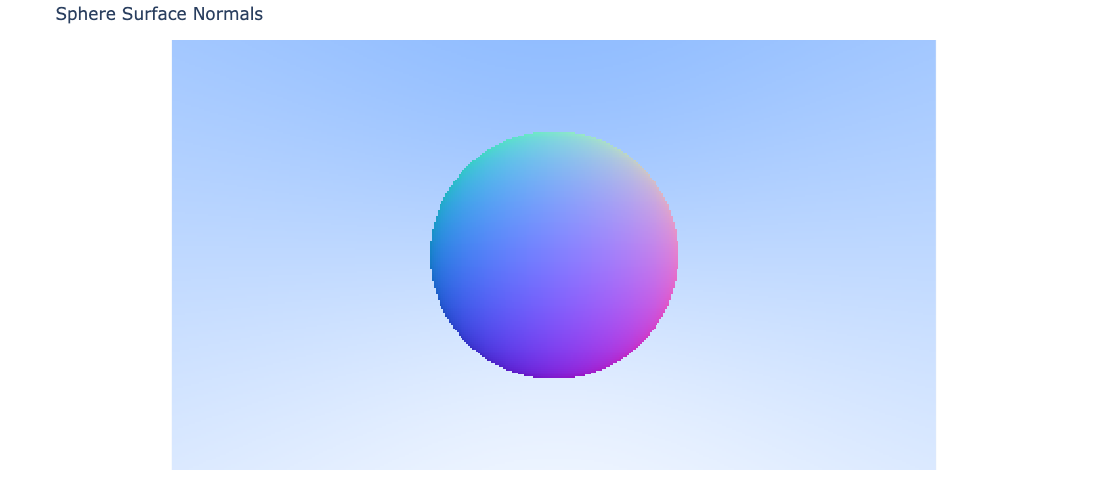

In [6]:
# Test: Render a single sphere showing normals
sphere = Sphere(
    center=torch.tensor([0.0, 0.0, -1.0], device=device),
    radius=0.5,
)

# Create origins tensor matching ray_dirs shape
origins = camera.origin.view(1, 1, 3).expand(height, width, 3)
rec = hit_sphere(origins, ray_dirs, sphere)

# Color by normal (map [-1,1] to [0,1])
normal_colors = (rec.normal + 1) / 2

# Blend with sky where no hit
image = torch.where(rec.hit.unsqueeze(-1), normal_colors, sky)
show_image(image, "Sphere Surface Normals")

---
## Part 4: Multiple Objects and a Ground Plane

Let's add more spheres and hit test against all of them, keeping the closest intersection.

In [8]:
def hit_scene(
    origins: torch.Tensor,
    directions: torch.Tensor,
    spheres: list[Sphere],
    t_min: float = 0.001,
    t_max: float = float("inf"),
) -> HitRecord:
    """Find closest intersection with any sphere in the scene."""
    batch_shape = origins.shape[:-1]
    device = origins.device

    # Initialize with no hits
    closest_t = torch.full(batch_shape, t_max, device=device)
    closest_hit = torch.zeros(batch_shape, dtype=torch.bool, device=device)
    closest_point = torch.zeros(*batch_shape, 3, device=device)
    closest_normal = torch.zeros(*batch_shape, 3, device=device)
    closest_front_face = torch.zeros(
        batch_shape, dtype=torch.bool, device=device
    )
    closest_material_id = torch.zeros(
        batch_shape, dtype=torch.long, device=device
    )

    for sphere in spheres:
        rec = hit_sphere(origins, directions, sphere, t_min, closest_t)

        # Update where this sphere is closer
        closer = rec.hit & (rec.t < closest_t)
        closest_t = torch.where(closer, rec.t, closest_t)
        closest_hit = closest_hit | closer
        closest_point = torch.where(
            closer.unsqueeze(-1), rec.point, closest_point
        )
        closest_normal = torch.where(
            closer.unsqueeze(-1), rec.normal, closest_normal
        )
        closest_front_face = torch.where(
            closer, rec.front_face, closest_front_face
        )
        closest_material_id = torch.where(
            closer, rec.material_id, closest_material_id
        )

    return HitRecord(
        t=closest_t,
        point=closest_point,
        normal=closest_normal,
        front_face=closest_front_face,
        material_id=closest_material_id,
        hit=closest_hit,
    )

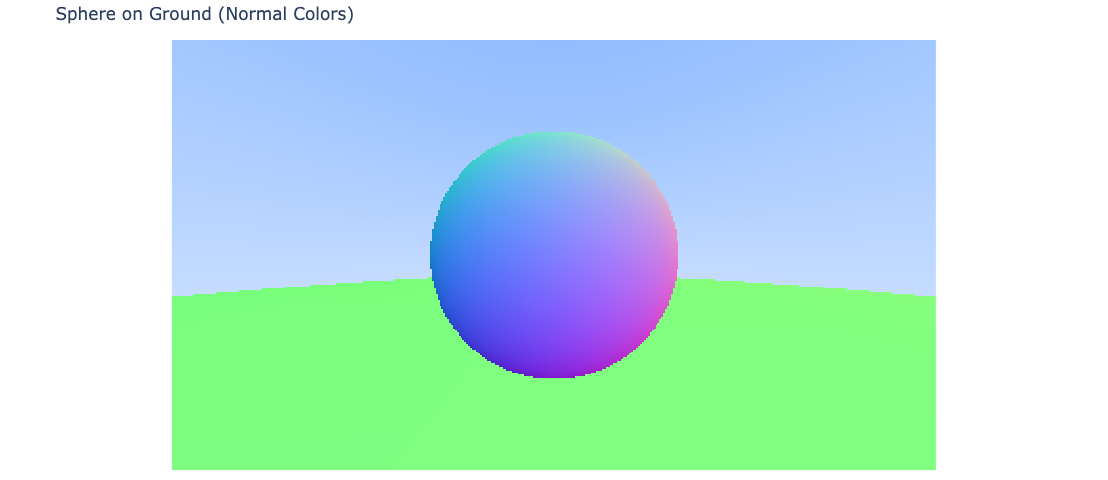

In [9]:
# Create a simple scene: sphere on a ground plane (large sphere)
scene = [
    Sphere(torch.tensor([0.0, 0.0, -1.0], device=device), 0.5, material_id=0),
    Sphere(
        torch.tensor([0.0, -100.5, -1.0], device=device), 100.0, material_id=1
    ),  # Ground
]

rec = hit_scene(origins, ray_dirs, scene)

# Visualize with normals
normal_colors = (rec.normal + 1) / 2
image = torch.where(rec.hit.unsqueeze(-1), normal_colors, sky)
show_image(image, "Sphere on Ground (Normal Colors)")

---
## Part 5: Diffuse Materials (Lambertian)

Matte objects scatter light randomly. For Lambertian reflection, we bounce rays in random directions biased toward the surface normal.

**Key insight:** Diffuse surfaces appear the same brightness from any viewing angle because they scatter uniformly in all directions.

In [10]:
@dataclass
class Material:
    """Material definition."""

    albedo: torch.Tensor  # Base color (R, G, B)
    material_type: str  # 'diffuse', 'metal', 'dielectric'
    roughness: float = 0.0  # For metals: 0=mirror, 1=fuzzy
    ior: float = 1.5  # For dielectrics: index of refraction


def random_unit_vector(shape: tuple, device="cpu") -> torch.Tensor:
    """Generate random unit vectors (uniform on sphere surface)."""
    # Use rejection sampling for true uniformity
    vec = torch.randn(*shape, 3, device=device)
    return F.normalize(vec, dim=-1)


def random_in_hemisphere(normal: torch.Tensor) -> torch.Tensor:
    """Generate random vectors in the hemisphere around normal."""
    random_vec = random_unit_vector(normal.shape[:-1], device=normal.device)
    # Flip if pointing away from normal
    same_hemisphere = (random_vec * normal).sum(dim=-1) > 0
    return torch.where(same_hemisphere.unsqueeze(-1), random_vec, -random_vec)


def lambertian_scatter(normal: torch.Tensor) -> torch.Tensor:
    """Compute Lambertian scatter direction."""
    # Cosine-weighted: normal + random unit vector
    scatter_dir = normal + random_unit_vector(normal.shape[:-1], normal.device)
    # Handle degenerate case where random vector ≈ -normal
    near_zero = (scatter_dir.abs() < 1e-8).all(dim=-1)
    scatter_dir = torch.where(near_zero.unsqueeze(-1), normal, scatter_dir)
    return F.normalize(scatter_dir, dim=-1)

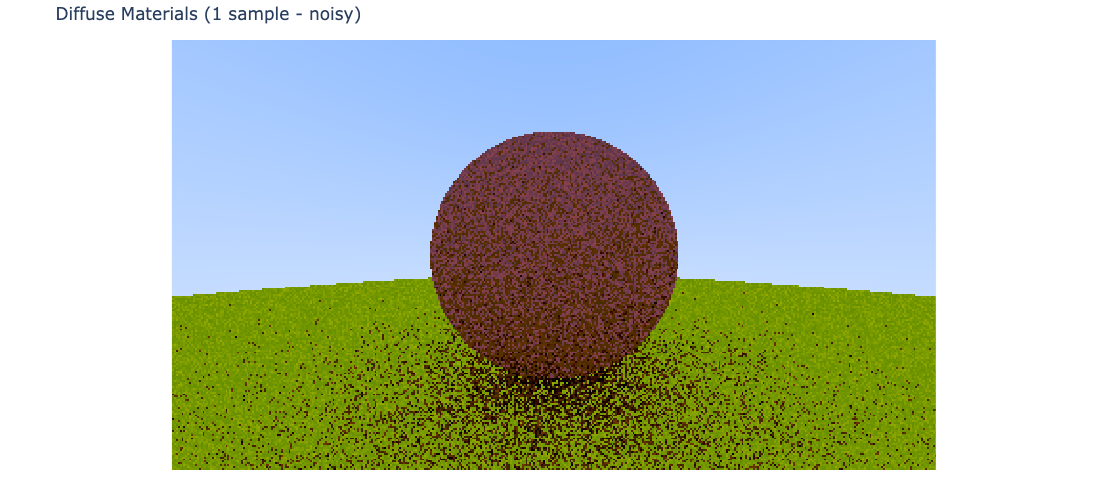

In [11]:
def ray_color_diffuse(
    origins: torch.Tensor,
    directions: torch.Tensor,
    spheres: list[Sphere],
    materials: list[Material],
    max_bounces: int = 10,
) -> torch.Tensor:
    """
    Trace rays with simple diffuse materials.

    Uses iterative bouncing instead of recursion for GPU efficiency.
    """
    device = origins.device
    batch_shape = origins.shape[:-1]

    # Accumulated color and attenuation
    color = torch.zeros(*batch_shape, 3, device=device)
    attenuation = torch.ones(*batch_shape, 3, device=device)

    # Current ray state
    ray_origin = origins.clone()
    ray_dir = directions.clone()
    active = torch.ones(batch_shape, dtype=torch.bool, device=device)

    for bounce in range(max_bounces):
        if not active.any():
            break

        rec = hit_scene(ray_origin, ray_dir, spheres)

        # Rays that hit something bounce
        hit_mask = active & rec.hit
        miss_mask = active & ~rec.hit

        # Add sky color for misses
        sky_contribution = sky_color(ray_dir) * attenuation
        color = torch.where(
            miss_mask.unsqueeze(-1), color + sky_contribution, color
        )

        # Update attenuation for hits
        for i, mat in enumerate(materials):
            mat_mask = hit_mask & (rec.material_id == i)
            if mat_mask.any():
                attenuation = torch.where(
                    mat_mask.unsqueeze(-1),
                    attenuation * mat.albedo,
                    attenuation,
                )

        # Scatter rays
        scatter_dir = lambertian_scatter(rec.normal)
        ray_origin = torch.where(hit_mask.unsqueeze(-1), rec.point, ray_origin)
        ray_dir = torch.where(hit_mask.unsqueeze(-1), scatter_dir, ray_dir)

        # Mark misses as done
        active = active & rec.hit

    # Rays that exhausted bounces get no additional light
    return color


# Define materials
materials = [
    Material(
        torch.tensor([0.7, 0.3, 0.3], device=device), "diffuse"
    ),  # Red-ish
    Material(
        torch.tensor([0.8, 0.8, 0.0], device=device), "diffuse"
    ),  # Yellow ground
]

# Render (single sample - will be noisy)
image = ray_color_diffuse(origins, ray_dirs, scene, materials, max_bounces=10)
show_image(image, "Diffuse Materials (1 sample - noisy)")

---
## Part 6: Antialiasing

The image is noisy because we're only taking one random sample per pixel. By averaging multiple samples with slight random offsets, we get:
1. **Smoother edges** (antialiasing)
2. **Less noise** in diffuse areas (Monte Carlo convergence)

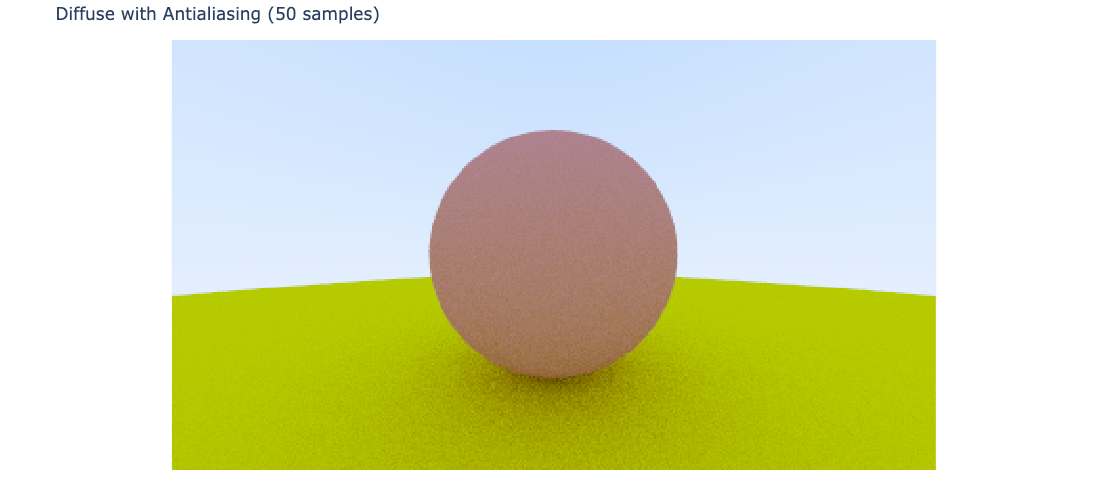

In [12]:
def render_scene(
    camera: Camera,
    spheres: list[Sphere],
    materials: list[Material],
    width: int,
    height: int,
    samples_per_pixel: int = 16,
    max_bounces: int = 10,
    ray_color_fn=ray_color_diffuse,
) -> torch.Tensor:
    """Render scene with antialiasing via multisampling."""
    device = camera.origin.device

    # Accumulate samples
    color_sum = torch.zeros(height, width, 3, device=device)

    for s in range(samples_per_pixel):
        # Random offset within pixel
        u_offset = torch.rand(height, width, device=device) / width
        v_offset = torch.rand(height, width, device=device) / height

        u, v = generate_pixel_coords(width, height, device=device)
        u = u + u_offset  # u is already (height, width)
        v = v - v_offset  # v is already (height, width)

        ray_dirs = camera.get_ray_directions(u, v)
        origins = camera.origin.view(1, 1, 3).expand(height, width, 3)

        color_sum += ray_color_fn(
            origins, ray_dirs, spheres, materials, max_bounces
        )

    return color_sum / samples_per_pixel


# Render with more samples
image = render_scene(
    camera,
    scene,
    materials,
    width,
    height,
    samples_per_pixel=50,
    max_bounces=10,
)

# Apply gamma correction (linear -> sRGB) using IEC 61966-2-1 transfer function
image_gamma = srgb_linear_to_srgb(image)
show_image(image_gamma, "Diffuse with Antialiasing (50 samples)")

---
## Part 7: Specular Highlights with Cook-Torrance BRDF

Now let's use `torchscience.graphics.shading.cook_torrance` to add realistic specular highlights.

**Cook-Torrance BRDF** is the gold standard for physically-based rendering:
- **GGX normal distribution** - realistic highlight shape
- **Smith geometry** - self-shadowing at grazing angles  
- **Schlick Fresnel** - edge brightening

We'll add a directional light and compute direct lighting with the PBR BRDF.

In [13]:
def ray_color_pbr(
    origins: torch.Tensor,
    directions: torch.Tensor,
    spheres: list[Sphere],
    materials: list[Material],
    max_bounces: int = 10,
    light_dir: Optional[torch.Tensor] = None,
    light_intensity: float = 1.0,
) -> torch.Tensor:
    """
    Trace rays with PBR materials using Cook-Torrance BRDF.

    Combines:
    - Indirect lighting via path tracing (diffuse bounces)
    - Direct lighting with Cook-Torrance specular
    """
    device = origins.device
    batch_shape = origins.shape[:-1]

    if light_dir is None:
        light_dir = F.normalize(
            torch.tensor([1.0, 1.0, 1.0], device=device), dim=-1
        )

    # State
    color = torch.zeros(*batch_shape, 3, device=device)
    attenuation = torch.ones(*batch_shape, 3, device=device)
    ray_origin = origins.clone()
    ray_dir = directions.clone()
    active = torch.ones(batch_shape, dtype=torch.bool, device=device)

    for bounce in range(max_bounces):
        if not active.any():
            break

        rec = hit_scene(ray_origin, ray_dir, spheres)
        hit_mask = active & rec.hit
        miss_mask = active & ~rec.hit

        # Sky for misses
        sky_contribution = sky_color(ray_dir) * attenuation
        color = torch.where(
            miss_mask.unsqueeze(-1), color + sky_contribution, color
        )

        if hit_mask.any():
            # View direction (from surface toward camera)
            view_dir = -ray_dir

            # Direct lighting with Cook-Torrance
            # Expand light_dir to match batch
            light_dir_batch = light_dir.expand(*batch_shape, 3)

            for i, mat in enumerate(materials):
                mat_mask = hit_mask & (rec.material_id == i)
                if mat_mask.any():
                    # Lambertian diffuse contribution
                    n_dot_l = (
                        (rec.normal * light_dir_batch).sum(dim=-1).clamp(min=0)
                    )
                    diffuse = mat.albedo / math.pi * n_dot_l.unsqueeze(-1)

                    # Cook-Torrance specular
                    # Ensure normals are normalized
                    normal_norm = F.normalize(rec.normal, dim=-1)
                    view_norm = F.normalize(view_dir, dim=-1)
                    light_norm = F.normalize(light_dir_batch, dim=-1)

                    # Compute specular BRDF
                    # Use higher roughness for diffuse materials
                    roughness = (
                        0.9
                        if mat.material_type == "diffuse"
                        else mat.roughness
                    )
                    f0 = (
                        0.04 if mat.material_type == "diffuse" else 0.9
                    )  # Dielectric vs metal

                    specular = cook_torrance(
                        normal_norm,
                        view_norm,
                        light_norm,
                        roughness=roughness,
                        f0=f0,
                    )

                    # Combine diffuse + specular
                    direct = (
                        diffuse + specular.unsqueeze(-1) * 0.5
                    ) * light_intensity

                    # Add direct lighting contribution
                    color = torch.where(
                        mat_mask.unsqueeze(-1),
                        color + attenuation * direct,
                        color,
                    )

                    # Update attenuation for next bounce
                    attenuation = torch.where(
                        mat_mask.unsqueeze(-1),
                        attenuation * mat.albedo * 0.5,  # Energy conservation
                        attenuation,
                    )

        # Scatter for next bounce (diffuse)
        scatter_dir = lambertian_scatter(rec.normal)
        ray_origin = torch.where(hit_mask.unsqueeze(-1), rec.point, ray_origin)
        ray_dir = torch.where(hit_mask.unsqueeze(-1), scatter_dir, ray_dir)
        active = active & rec.hit

    return color

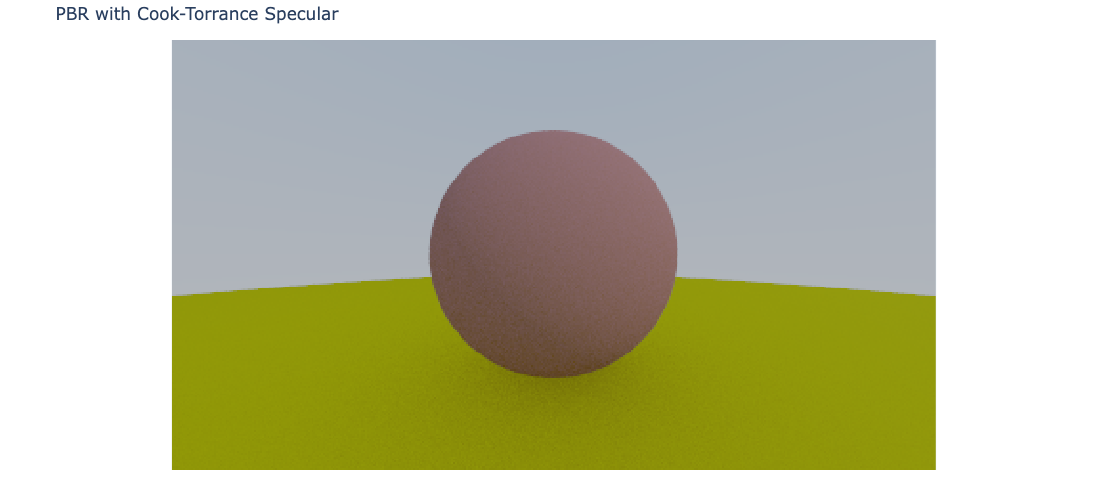

In [14]:
# Render with PBR
light_direction = F.normalize(
    torch.tensor([1.0, 1.0, 0.5], device=device), dim=-1
)


def ray_color_pbr_with_light(
    origins, directions, spheres, materials, max_bounces
):
    return ray_color_pbr(
        origins,
        directions,
        spheres,
        materials,
        max_bounces,
        light_dir=light_direction,
        light_intensity=1.0,
    )


image = render_scene(
    camera,
    scene,
    materials,
    width,
    height,
    samples_per_pixel=50,
    max_bounces=5,
    ray_color_fn=ray_color_pbr_with_light,
)

# Tone mapping with Reinhard and gamma correction (IEC 61966-2-1 sRGB)
image_tonemapped = reinhard(image)
image_gamma = srgb_linear_to_srgb(image_tonemapped)
show_image(image_gamma, "PBR with Cook-Torrance Specular")

---
## Part 8: Metal Materials (Reflections)

Metals reflect light specularly. Perfect mirrors reflect the incident ray about the normal.

**Reflection formula:** R = D - 2(D·N)N

Adding `roughness` fuzzes the reflection by adding random perturbation.

In [15]:
def ray_color_with_metals(
    origins: torch.Tensor,
    directions: torch.Tensor,
    spheres: list[Sphere],
    materials: list[Material],
    max_bounces: int = 10,
    light_dir: Optional[torch.Tensor] = None,
    light_intensity: float = 1.0,
) -> torch.Tensor:
    """Ray tracing with diffuse, metal, and specular materials."""
    device = origins.device
    batch_shape = origins.shape[:-1]

    if light_dir is None:
        light_dir = F.normalize(
            torch.tensor([1.0, 1.0, 1.0], device=device), dim=-1
        )

    color = torch.zeros(*batch_shape, 3, device=device)
    attenuation = torch.ones(*batch_shape, 3, device=device)
    ray_origin = origins.clone()
    ray_dir = directions.clone()
    active = torch.ones(batch_shape, dtype=torch.bool, device=device)

    for bounce in range(max_bounces):
        if not active.any():
            break

        rec = hit_scene(ray_origin, ray_dir, spheres)
        hit_mask = active & rec.hit
        miss_mask = active & ~rec.hit

        # Sky for misses
        sky_contribution = sky_color(ray_dir) * attenuation
        color = torch.where(
            miss_mask.unsqueeze(-1), color + sky_contribution, color
        )

        # Process each material type
        scatter_dir = ray_dir.clone()  # Default: keep going

        for i, mat in enumerate(materials):
            mat_mask = hit_mask & (rec.material_id == i)
            if not mat_mask.any():
                continue

            if mat.material_type == "diffuse":
                # Lambertian scatter
                new_dir = lambertian_scatter(rec.normal)
                scatter_dir = torch.where(
                    mat_mask.unsqueeze(-1), new_dir, scatter_dir
                )

                # Direct lighting
                light_dir_batch = light_dir.expand(*batch_shape, 3)
                n_dot_l = (
                    (rec.normal * light_dir_batch).sum(dim=-1).clamp(min=0)
                )
                diffuse = mat.albedo * n_dot_l.unsqueeze(-1) * light_intensity
                color = torch.where(
                    mat_mask.unsqueeze(-1),
                    color + attenuation * diffuse * 0.5,
                    color,
                )

            elif mat.material_type == "metal":
                # Reflection with optional fuzz
                reflected = reflect(F.normalize(ray_dir, dim=-1), rec.normal)
                if mat.roughness > 0:
                    fuzz = (
                        random_unit_vector(batch_shape, device) * mat.roughness
                    )
                    reflected = F.normalize(reflected + fuzz, dim=-1)
                scatter_dir = torch.where(
                    mat_mask.unsqueeze(-1), reflected, scatter_dir
                )

                # Metals absorb based on albedo
                # Check reflection is above surface
                valid_reflect = (reflected * rec.normal).sum(dim=-1) > 0
                active = torch.where(mat_mask, active & valid_reflect, active)

            # Update attenuation
            attenuation = torch.where(
                mat_mask.unsqueeze(-1), attenuation * mat.albedo, attenuation
            )

        # Update ray state
        ray_origin = torch.where(hit_mask.unsqueeze(-1), rec.point, ray_origin)
        ray_dir = torch.where(hit_mask.unsqueeze(-1), scatter_dir, ray_dir)
        active = active & rec.hit

    return color

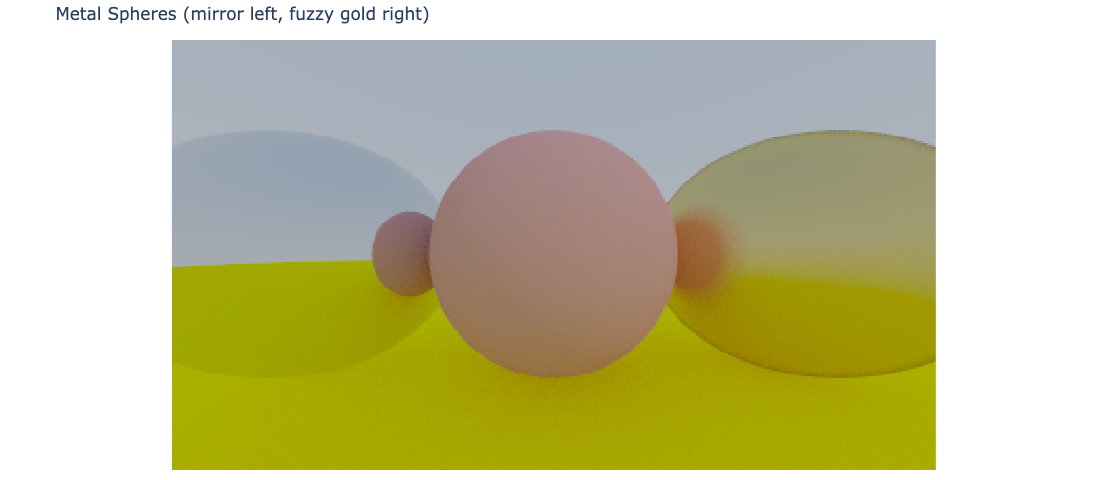

In [16]:
# Scene with metal spheres
scene_metal = [
    Sphere(
        torch.tensor([0.0, 0.0, -1.0], device=device), 0.5, material_id=0
    ),  # Center diffuse
    Sphere(
        torch.tensor([-1.0, 0.0, -1.0], device=device), 0.5, material_id=1
    ),  # Left metal
    Sphere(
        torch.tensor([1.0, 0.0, -1.0], device=device), 0.5, material_id=2
    ),  # Right fuzzy metal
    Sphere(
        torch.tensor([0.0, -100.5, -1.0], device=device), 100.0, material_id=3
    ),  # Ground
]

materials_metal = [
    Material(torch.tensor([0.7, 0.3, 0.3], device=device), "diffuse"),
    Material(
        torch.tensor([0.8, 0.8, 0.8], device=device), "metal", roughness=0.0
    ),  # Mirror
    Material(
        torch.tensor([0.8, 0.6, 0.2], device=device), "metal", roughness=0.3
    ),  # Gold fuzzy
    Material(torch.tensor([0.8, 0.8, 0.0], device=device), "diffuse"),
]


def ray_color_metal(origins, directions, spheres, materials, max_bounces):
    return ray_color_with_metals(
        origins,
        directions,
        spheres,
        materials,
        max_bounces,
        light_dir=light_direction,
        light_intensity=0.8,
    )


image = render_scene(
    camera,
    scene_metal,
    materials_metal,
    width,
    height,
    samples_per_pixel=100,
    max_bounces=10,
    ray_color_fn=ray_color_metal,
)

image_tonemapped = reinhard(image)
image_gamma = srgb_linear_to_srgb(image_tonemapped)
show_image(image_gamma, "Metal Spheres (mirror left, fuzzy gold right)")

---
## Part 9: Glass Materials (Dielectrics)

Glass and water refract light. The direction change follows **Snell's law**:

η sin(θ) = η' sin(θ')

Where η is the index of refraction (IOR):
- Air: 1.0
- Glass: 1.5
- Water: 1.33
- Diamond: 2.4

Real glass also reflects some light, especially at grazing angles (**Fresnel effect**). We use the **Schlick approximation** for efficiency.

In [17]:
def ray_color_full(
    origins: torch.Tensor,
    directions: torch.Tensor,
    spheres: list[Sphere],
    materials: list[Material],
    max_bounces: int = 10,
    light_dir: Optional[torch.Tensor] = None,
    light_intensity: float = 1.0,
) -> torch.Tensor:
    """Full ray tracer with diffuse, metal, and dielectric materials."""
    device = origins.device
    batch_shape = origins.shape[:-1]

    if light_dir is None:
        light_dir = F.normalize(
            torch.tensor([1.0, 1.0, 1.0], device=device), dim=-1
        )

    color = torch.zeros(*batch_shape, 3, device=device)
    attenuation = torch.ones(*batch_shape, 3, device=device)
    ray_origin = origins.clone()
    ray_dir = F.normalize(directions.clone(), dim=-1)
    active = torch.ones(batch_shape, dtype=torch.bool, device=device)

    for bounce in range(max_bounces):
        if not active.any():
            break

        rec = hit_scene(ray_origin, ray_dir, spheres)
        hit_mask = active & rec.hit
        miss_mask = active & ~rec.hit

        # Sky for misses
        sky_contribution = sky_color(ray_dir) * attenuation
        color = torch.where(
            miss_mask.unsqueeze(-1), color + sky_contribution, color
        )

        scatter_dir = ray_dir.clone()
        new_attenuation = attenuation.clone()

        for i, mat in enumerate(materials):
            mat_mask = hit_mask & (rec.material_id == i)
            if not mat_mask.any():
                continue

            if mat.material_type == "diffuse":
                new_dir = lambertian_scatter(rec.normal)
                scatter_dir = torch.where(
                    mat_mask.unsqueeze(-1), new_dir, scatter_dir
                )

                # Direct lighting
                light_dir_batch = light_dir.expand(*batch_shape, 3)
                n_dot_l = (
                    (rec.normal * light_dir_batch).sum(dim=-1).clamp(min=0)
                )
                diffuse = mat.albedo * n_dot_l.unsqueeze(-1) * light_intensity
                color = torch.where(
                    mat_mask.unsqueeze(-1),
                    color + attenuation * diffuse * 0.3,
                    color,
                )
                new_attenuation = torch.where(
                    mat_mask.unsqueeze(-1),
                    attenuation * mat.albedo,
                    new_attenuation,
                )

            elif mat.material_type == "metal":
                reflected = reflect(ray_dir, rec.normal)
                if mat.roughness > 0:
                    fuzz = (
                        random_unit_vector(batch_shape, device) * mat.roughness
                    )
                    reflected = F.normalize(reflected + fuzz, dim=-1)
                scatter_dir = torch.where(
                    mat_mask.unsqueeze(-1), reflected, scatter_dir
                )
                new_attenuation = torch.where(
                    mat_mask.unsqueeze(-1),
                    attenuation * mat.albedo,
                    new_attenuation,
                )
                valid = (reflected * rec.normal).sum(dim=-1) > 0
                active = torch.where(mat_mask, active & valid, active)

            elif mat.material_type == "dielectric":
                # Refraction with Fresnel
                eta = torch.where(
                    rec.front_face,
                    torch.tensor(1.0 / mat.ior, device=device),
                    torch.tensor(mat.ior, device=device),
                )

                cos_theta = (-ray_dir * rec.normal).sum(dim=-1).clamp(max=1.0)
                sin_theta = torch.sqrt(1.0 - cos_theta**2)

                # Check for total internal reflection
                cannot_refract = eta * sin_theta > 1.0

                # Schlick reflectance (using torchscience operator)
                reflectance = schlick_reflectance(cos_theta, ior=mat.ior)
                should_reflect = cannot_refract | (
                    torch.rand(batch_shape, device=device) < reflectance
                )

                # Compute both directions (using torchscience operators)
                reflected = reflect(ray_dir, rec.normal)
                refracted = refract(ray_dir, rec.normal, eta)

                new_dir = torch.where(
                    should_reflect.unsqueeze(-1), reflected, refracted
                )
                scatter_dir = torch.where(
                    mat_mask.unsqueeze(-1), new_dir, scatter_dir
                )
                # Glass is clear - no attenuation change

        attenuation = new_attenuation
        ray_origin = torch.where(hit_mask.unsqueeze(-1), rec.point, ray_origin)
        ray_dir = torch.where(
            hit_mask.unsqueeze(-1), F.normalize(scatter_dir, dim=-1), ray_dir
        )
        active = active & rec.hit

    return color

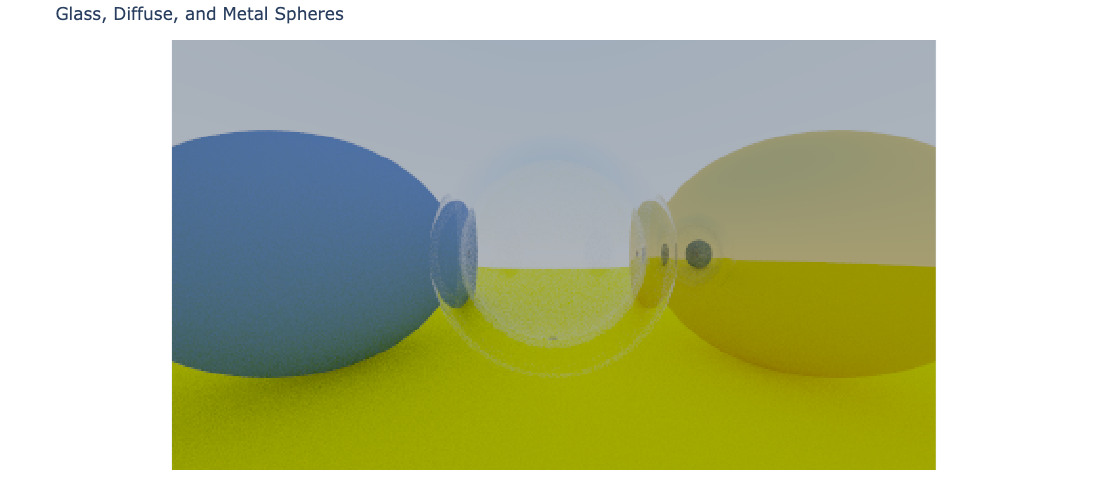

In [18]:
# Scene with all material types
scene_full = [
    Sphere(
        torch.tensor([0.0, 0.0, -1.0], device=device), 0.5, material_id=0
    ),  # Center glass
    Sphere(
        torch.tensor([0.0, 0.0, -1.0], device=device), -0.4, material_id=0
    ),  # Hollow glass (negative radius = invert normals)
    Sphere(
        torch.tensor([-1.0, 0.0, -1.0], device=device), 0.5, material_id=1
    ),  # Left diffuse
    Sphere(
        torch.tensor([1.0, 0.0, -1.0], device=device), 0.5, material_id=2
    ),  # Right metal
    Sphere(
        torch.tensor([0.0, -100.5, -1.0], device=device), 100.0, material_id=3
    ),  # Ground
]

materials_full = [
    Material(
        torch.tensor([1.0, 1.0, 1.0], device=device), "dielectric", ior=1.5
    ),
    Material(torch.tensor([0.1, 0.2, 0.5], device=device), "diffuse"),
    Material(
        torch.tensor([0.8, 0.6, 0.2], device=device), "metal", roughness=0.0
    ),
    Material(torch.tensor([0.8, 0.8, 0.0], device=device), "diffuse"),
]


def ray_color_wrapper(origins, directions, spheres, materials, max_bounces):
    return ray_color_full(
        origins,
        directions,
        spheres,
        materials,
        max_bounces,
        light_dir=light_direction,
        light_intensity=0.8,
    )


image = render_scene(
    camera,
    scene_full,
    materials_full,
    width,
    height,
    samples_per_pixel=100,
    max_bounces=20,
    ray_color_fn=ray_color_wrapper,
)

image_tonemapped = reinhard(image)
image_gamma = srgb_linear_to_srgb(image_tonemapped)
show_image(image_gamma, "Glass, Diffuse, and Metal Spheres")

---
## Part 10: Interactive Parameter Exploration

Let's add widgets to explore how parameters affect the render in real-time.

In [19]:
if WIDGETS_AVAILABLE:
    # Quick render for interactive exploration
    preview_width, preview_height = 200, 112

    @widgets.interact(
        roughness=widgets.FloatSlider(
            value=0.3,
            min=0.0,
            max=1.0,
            step=0.05,
            description="Metal Roughness",
        ),
        glass_ior=widgets.FloatSlider(
            value=1.5, min=1.0, max=2.5, step=0.1, description="Glass IOR"
        ),
        light_angle=widgets.FloatSlider(
            value=45, min=0, max=180, step=5, description="Light Angle"
        ),
        samples=widgets.IntSlider(
            value=20, min=1, max=100, step=5, description="Samples"
        ),
    )
    def interactive_render(roughness, glass_ior, light_angle, samples):
        # Update materials
        materials_interactive = [
            Material(
                torch.tensor([1.0, 1.0, 1.0], device=device),
                "dielectric",
                ior=glass_ior,
            ),
            Material(torch.tensor([0.1, 0.2, 0.5], device=device), "diffuse"),
            Material(
                torch.tensor([0.8, 0.6, 0.2], device=device),
                "metal",
                roughness=roughness,
            ),
            Material(torch.tensor([0.8, 0.8, 0.0], device=device), "diffuse"),
        ]

        # Update light direction
        angle_rad = math.radians(light_angle)
        light_dir = F.normalize(
            torch.tensor(
                [math.sin(angle_rad), 1.0, math.cos(angle_rad)], device=device
            ),
            dim=-1,
        )

        camera_preview = Camera(
            lookfrom=torch.tensor([0.0, 0.0, 0.0], device=device),
            lookat=torch.tensor([0.0, 0.0, -1.0], device=device),
            vup=torch.tensor([0.0, 1.0, 0.0], device=device),
            vfov=90.0,
            aspect_ratio=preview_width / preview_height,
        )

        def ray_fn(origins, directions, spheres, materials, max_bounces):
            return ray_color_full(
                origins,
                directions,
                spheres,
                materials,
                max_bounces,
                light_dir=light_dir,
                light_intensity=0.8,
            )

        image = render_scene(
            camera_preview,
            scene_full,
            materials_interactive,
            preview_width,
            preview_height,
            samples_per_pixel=samples,
            max_bounces=10,
            ray_color_fn=ray_fn,
        )

        img_np = (
            srgb_linear_to_srgb(reinhard(image)).clamp(0, 1).cpu().numpy()
            * 255
        ).astype("uint8")

        fig = px.imshow(img_np)
        fig.update_layout(
            title=f"Roughness={roughness:.2f}, IOR={glass_ior:.1f}, Samples={samples}",
            width=640,
            height=360,
            xaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
            yaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
            margin=dict(l=10, r=10, t=40, b=10),
        )
        fig.show()
else:
    print(
        "Interactive widgets not available. Install ipywidgets for real-time exploration."
    )

interactive(children=(FloatSlider(value=0.3, description='Metal Roughness', max=1.0, step=0.05), FloatSlider(v…

---
## Part 11: Color Space Exploration with HSV

Let's use `torchscience.graphics.color` to explore the HSV color space and create a rainbow of materials.

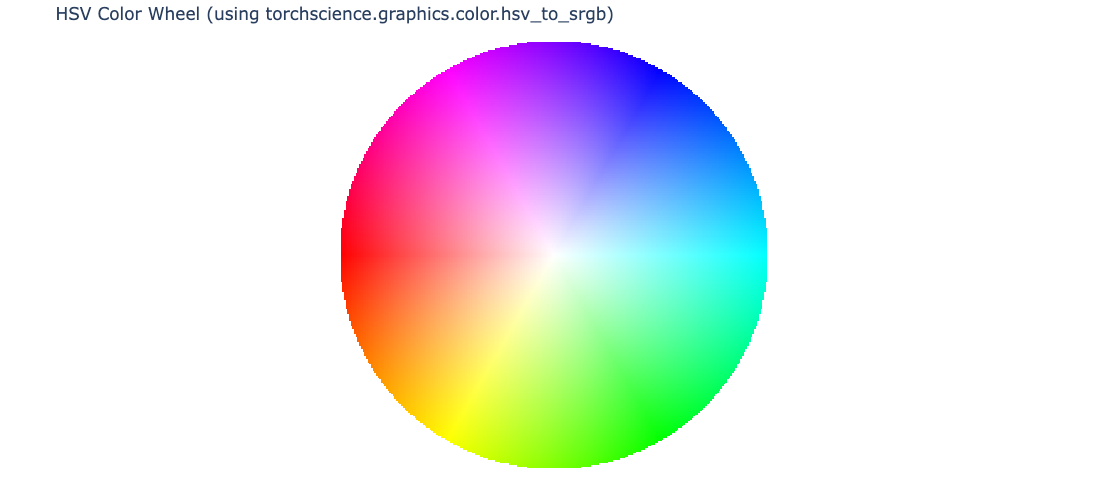

In [20]:
# Create HSV color wheel
wheel_size = 256
x = torch.linspace(-1, 1, wheel_size, device=device)
y = torch.linspace(-1, 1, wheel_size, device=device)
xx, yy = torch.meshgrid(x, y, indexing="xy")

# Polar coordinates
r = torch.sqrt(xx**2 + yy**2)
theta = torch.atan2(yy, xx)  # [-pi, pi]

# HSV: Hue from angle, Saturation from radius, Value = 1
h = (
    (theta + math.pi) / (2 * math.pi) * 2 * math.pi
)  # [0, 2*pi] for torchscience convention
s = r.clamp(0, 1)
v = torch.ones_like(r)

# Mask outside circle
mask = r <= 1.0

hsv = torch.stack([h, s, v], dim=-1)
rgb = hsv_to_srgb(hsv)

# Apply mask
rgb = torch.where(mask.unsqueeze(-1), rgb, torch.ones_like(rgb))

# Flip vertically so y increases upward (row 0 = top = y=1)
rgb_display = rgb.flip(0)
show_image(
    rgb_display,
    "HSV Color Wheel (using torchscience.graphics.color.hsv_to_srgb)",
)

In [21]:
# Demonstrate round-trip conversion
test_colors = torch.tensor(
    [
        [1.0, 0.0, 0.0],  # Red
        [0.0, 1.0, 0.0],  # Green
        [0.0, 0.0, 1.0],  # Blue
        [1.0, 1.0, 0.0],  # Yellow
        [1.0, 0.0, 1.0],  # Magenta
        [0.0, 1.0, 1.0],  # Cyan
    ],
    device=device,
)

hsv = srgb_to_hsv(test_colors)
rgb_back = hsv_to_srgb(hsv)

print("sRGB → HSV → sRGB Round-Trip:")
print(f"{'Original RGB':20} {'HSV (H in radians)':25} {'Recovered RGB':20}")
print("-" * 65)
for i in range(len(test_colors)):
    orig = test_colors[i].cpu().numpy()
    h_val = hsv[i].cpu().numpy()
    back = rgb_back[i].cpu().numpy()
    print(f"{str(orig):20} {str(h_val):25} {str(back):20}")

sRGB → HSV → sRGB Round-Trip:
Original RGB         HSV (H in radians)        Recovered RGB       
-----------------------------------------------------------------
[1. 0. 0.]           [0. 1. 1.]                [1. 0. 0.]          
[0. 1. 0.]           [2.0943952 1.        1.       ] [0. 1. 0.]          
[0. 0. 1.]           [4.1887903 1.        1.       ] [0. 0. 1.]          
[1. 1. 0.]           [1.0471976 1.        1.       ] [1. 1. 0.]          
[1. 0. 1.]           [5.2359877 1.        1.       ] [1. 0. 1.]          
[0. 1. 1.]           [3.1415927 1.        1.       ] [0. 1. 1.]          


---
## Part 12: The Grand Finale - Ray Tracing in One Weekend Cover Scene

Finally, let's recreate the iconic cover image from "Ray Tracing in One Weekend": a field of random spheres with various materials.

**Scene composition:**
- Ground plane (large sphere)
- Three large spheres: glass, diffuse, metal
- Many small random spheres with random materials
- Camera positioned above looking down at the scene

In [22]:
def create_random_scene(
    device="cpu", seed=42
) -> tuple[list[Sphere], list[Material]]:
    """Create the classic RTIOW random scene."""
    torch.manual_seed(seed)

    spheres = []
    materials = []

    # Ground
    materials.append(
        Material(torch.tensor([0.5, 0.5, 0.5], device=device), "diffuse")
    )
    spheres.append(
        Sphere(
            torch.tensor([0.0, -1000.0, 0.0], device=device),
            1000.0,
            material_id=0,
        )
    )

    # Small random spheres
    material_idx = 1
    for a in range(-11, 11):
        for b in range(-11, 11):
            choose_mat = torch.rand(1).item()
            center = torch.tensor(
                [
                    a + 0.9 * torch.rand(1).item(),
                    0.2,
                    b + 0.9 * torch.rand(1).item(),
                ],
                device=device,
            )

            # Skip if too close to big spheres
            if (
                center - torch.tensor([4.0, 0.2, 0.0], device=device)
            ).norm() < 0.9:
                continue

            if choose_mat < 0.8:
                # Diffuse
                albedo = torch.rand(3, device=device) * torch.rand(
                    3, device=device
                )
                materials.append(Material(albedo, "diffuse"))
            elif choose_mat < 0.95:
                # Metal
                albedo = torch.rand(3, device=device) * 0.5 + 0.5
                roughness = torch.rand(1).item() * 0.5
                materials.append(
                    Material(albedo, "metal", roughness=roughness)
                )
            else:
                # Glass
                materials.append(
                    Material(
                        torch.tensor([1.0, 1.0, 1.0], device=device),
                        "dielectric",
                        ior=1.5,
                    )
                )

            spheres.append(Sphere(center, 0.2, material_id=material_idx))
            material_idx += 1

    # Three big spheres
    # Glass
    materials.append(
        Material(
            torch.tensor([1.0, 1.0, 1.0], device=device), "dielectric", ior=1.5
        )
    )
    spheres.append(
        Sphere(
            torch.tensor([0.0, 1.0, 0.0], device=device),
            1.0,
            material_id=material_idx,
        )
    )
    material_idx += 1

    # Diffuse
    materials.append(
        Material(torch.tensor([0.4, 0.2, 0.1], device=device), "diffuse")
    )
    spheres.append(
        Sphere(
            torch.tensor([-4.0, 1.0, 0.0], device=device),
            1.0,
            material_id=material_idx,
        )
    )
    material_idx += 1

    # Metal
    materials.append(
        Material(
            torch.tensor([0.7, 0.6, 0.5], device=device),
            "metal",
            roughness=0.0,
        )
    )
    spheres.append(
        Sphere(
            torch.tensor([4.0, 1.0, 0.0], device=device),
            1.0,
            material_id=material_idx,
        )
    )

    return spheres, materials


# Create scene
final_spheres, final_materials = create_random_scene(device=device)
print(f"Scene: {len(final_spheres)} spheres, {len(final_materials)} materials")

Scene: 484 spheres, 484 materials


In [ ]:
# Final render settings
final_width = 600  # Increase for higher quality
final_height = 400
samples = 100  # Increase for less noise

# Camera position from RTIOW
lookfrom = torch.tensor([13.0, 2.0, 3.0], device=device)
lookat = torch.tensor([0.0, 0.0, 0.0], device=device)

final_camera = Camera(
    lookfrom=lookfrom,
    lookat=lookat,
    vup=torch.tensor([0.0, 1.0, 0.0], device=device),
    vfov=20.0,
    aspect_ratio=final_width / final_height,
)

# Light from above-right
final_light_dir = F.normalize(
    torch.tensor([1.0, 3.0, 1.0], device=device), dim=-1
)


def final_ray_color(origins, directions, spheres, materials, max_bounces):
    return ray_color_full(
        origins,
        directions,
        spheres,
        materials,
        max_bounces,
        light_dir=final_light_dir,
        light_intensity=0.6,
    )


print(f"Rendering {final_width}x{final_height} @ {samples} samples...")
print("This may take a few minutes on CPU.")

import time

start_time = time.time()

final_image = render_scene(
    final_camera,
    final_spheres,
    final_materials,
    final_width,
    final_height,
    samples_per_pixel=samples,
    max_bounces=15,
    ray_color_fn=final_ray_color,
)

elapsed = time.time() - start_time
print(f"Render completed in {elapsed:.1f}s")

# Post-processing: tone mapping and gamma correction (IEC 61966-2-1 sRGB)
final_tonemapped = reinhard(final_image, white_point=2.0)
final_gamma = srgb_linear_to_srgb(final_tonemapped)

show_image(
    final_gamma, "Ray Tracing in One Weekend - Final Scene", figsize=(12, 8)
)

Rendering 600x400 @ 100 samples...
This may take a few minutes on CPU.


In [ ]:
# Save the final render
import numpy as np
from PIL import Image

# Convert to 8-bit image
img_np = (final_gamma.clamp(0, 1).cpu().numpy() * 255).astype(np.uint8)
img_pil = Image.fromarray(img_np)
img_pil.save("rtiow_final_scene.png")
print("Saved to rtiow_final_scene.png")

---
## Summary

We built a complete ray tracer using `torchscience`:

| Component | torchscience Function | Purpose |
|-----------|----------------------|--------|
| Specular highlights | `cook_torrance` | Physically-based BRDF |
| Reflection | `reflect` | Mirror-like reflection for metals |
| Refraction | `refract` | Glass/dielectric light bending |
| Fresnel effect | `schlick_reflectance` | Angle-dependent reflectivity |
| Color manipulation | `srgb_to_hsv`, `hsv_to_srgb` | Color space conversion |
| Gamma correction | `srgb_linear_to_srgb` | IEC 61966-2-1 sRGB transfer function |
| Tone mapping | `reinhard` | HDR to displayable LDR |

**Key concepts covered:**
1. Camera ray generation with perspective projection
2. Ray-sphere intersection (analytic quadratic solution)
3. Surface normals for shading
4. Lambertian diffuse scattering
5. Specular reflection for metals
6. Refraction for glass (Snell's law + Schlick Fresnel)
7. Monte Carlo antialiasing
8. Reinhard tone mapping for HDR rendering

**Next steps:**
- Use `torchscience.geometry.ray_intersect` for triangle meshes
- Add depth of field with defocus blur
- Implement importance sampling for faster convergence
- Explore motion blur with temporal samples

Happy ray tracing!